#  Homework 2

Deadline: March 10th 11:59pm

Hand in: the homework must be handed in through the Moodle system. 

<span style="color:red">Provide a written answer if requested in the exercise! These questions are marked in red.</span>

---

## Exercise 1 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import string

APIs are a great way to collect data for your projects. Here are a few API you can try out:

- https://developer.nytimes.com/docs/archive-product/1/overview
- https://api.wikimedia.org/wiki/Getting_started_with_Wikimedia_APIs
- https://api.semanticscholar.org/api-docs/graph#tag/Paper-Data/operation/get_graph_get_paper_citations

In this exercise you'll collect and clean data from an API. This could be a good oportunity to collect data for your final project. (20%)

**a)** Collect data from an API of your choice. Proccess the returned data so that each unique data feature is a column in a pandas dataframe. Investigate missing data, such as NaN values, and apply a solution. Cast data columns to be the right type for the data they contain. Display the cleaned data frame using .head().

In [2]:
secret = 'p5MeHdhDzT8FKOAP'
api_key = 'wN4cedJ5JutIrOSFuEemKgh6kJdgNfvd'

In [3]:
def fetch_headlines(api_key, year, month):
    article_list = []
    
    base_url = "https://api.nytimes.com/svc/archive/v1/{}/{}.json".format(year, month)
    params = {"api-key": api_key}
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        articles = data['response']['docs']
        for article in articles:
            article_list.append(article['headline']['main'])
    else:
        print("Failed to fetch data:", response.status_code)
    return article_list

In [4]:
# I was born in February 2002
headlines_list = fetch_headlines(api_key, 2002, 2)

In [5]:
def cleanAndSplit(sentence):
    punctuation_to_remove = string.punctuation.replace('-', '')  # keep hyphens, for compound words
    clean_sentence = sentence.translate(str.maketrans('', '', punctuation_to_remove)).lower()
    words = clean_sentence.split()
    return words

In [6]:
words_df = pd.DataFrame(columns=['Word', 'Count'])
for headline in headlines_list:
    for word in cleanAndSplit(headline):
        if word in words_df['Word'].values:
            words_df.loc[words_df['Word'] == word, 'Count'] += 1  
        else:
            new_row = {'Word': word, 'Count': 1}
            words_df = pd.concat([words_df, pd.DataFrame([new_row])], ignore_index=True)
words_df['Count'] = words_df['Count'].astype(int)

In [7]:
print(words_df.head())

       Word  Count
0         a   1419
1  grandeur      1
2  inspired      3
3        by    163
4       the   1539


**b)** Use the dataframe created in part a) to answer an exploratory data analysis question of your choice. State your question, design a data visualization that answers your question and <span style="color:red">discuss</span>.

<span style="color:blue">**Question:**    
What are the most common words used in New York Times headlines in the month I was born?   
Except for generally common words like 'a', 'is', 'the',....</span>

In [8]:
wordsToDrop = ['the', 'how', 'this', 'was', 'a', 'to', 'in', 'some', 'of', 'for', 'j', 'and', 'on', 'is', '2', 'at', 'with', 'from', 'us', 'an', 'by', 'as', 'its', 'are', 'it', 'but', 'not', 'will', 'after', 'that', 'over', 'no', 'out', 'or', 'up', 'says', 'be', 'who', 'off', 'his', 'more', 'has', 'into', 'can', 'say', 'all', 'about', 'when', 'may', 'what']
to_plot_df = words_df[~words_df['Word'].isin(wordsToDrop)]
to_plot_df = to_plot_df.nlargest(50, 'Count')

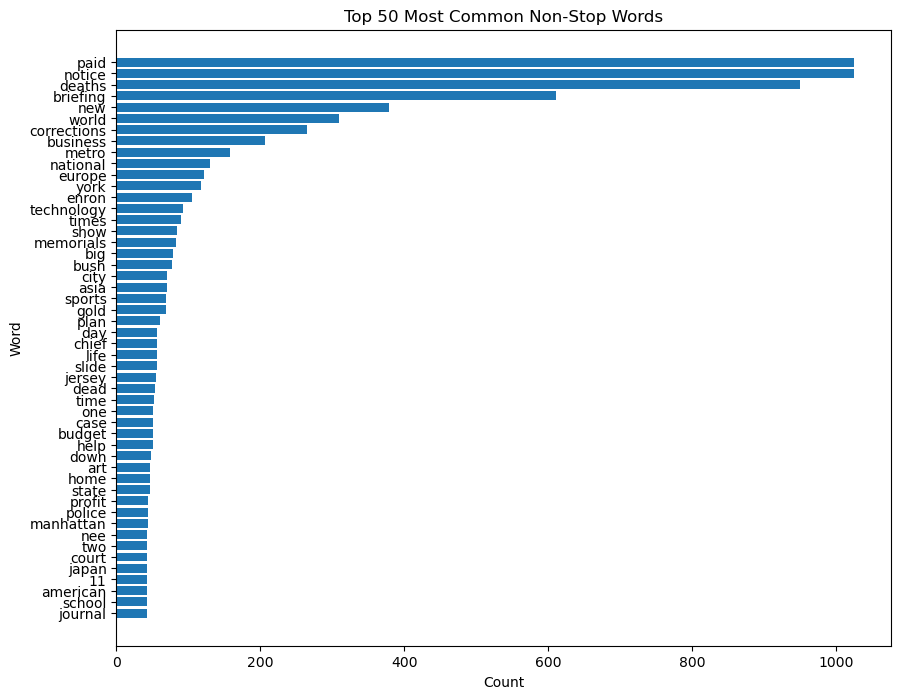

In [9]:
plt.figure(figsize=(10, 8))
plt.barh(to_plot_df['Word'], to_plot_df['Count'])
plt.xlabel('Count')
plt.ylabel('Word')
plt.title('Top 50 Most Common Non-Stop Words')
plt.gca().invert_yaxis()
plt.show()

<span style="color:blue"> Most of the words are ones we would generally expect to see in regular news, and are probably not particular to the timeframe we queried, but the ones that stand out to me here are:</span>
1. Enron: The Enron scandal happened in December of 2001, so two months later, it makes sense that the NYT would still be heavily covering the fallout.
2. Gold: The price of gold plummeted in late 2001 (because of 9/11) and had just stared rising again in early 2002.
3. Japan: The 2002 world cup was held in Japan.
4. Manhattan: Either has to do with the Jennifer Lopez movie "Maid in Manhattan" being released, or post 9/11-related news. Perhaps both.
5. Deaths, Dead, Dies: 9/11 happened two short months before.
6. Bush: Of course, Bush was the American president in 2002, and had just given his 'axis of evil' state of the address at the end of January, 2002.
7. 11: The September 11 attacks happened the previous year and was probably still being covered.


## Exercise 2 

In [10]:
from urllib.request import urlopen

import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

import time
import os
import wordcloud
from wordcloud import WordCloud

The [Round University Ranking (RUR)](https://roundranking.com/ranking/world-university-rankings.html#world-2021) evaluates the performance of 867 world’s leading higher education institutions by 20 indicators grouped into 4 key areas of university activity: Teaching, Research, International Diversity, Financial Sustainability. The top 100 universities are placed in the diamond league, the next 100 in the gold league and so on... (40%)

**a)**  Using the scraping techniques covered in class, scrape the following data fields about the universities (from the website linked above): The name of the University, in which country the University is located, their score and league given by the RUR ranking. Then load the data into a Pandas DataFrame called *df* with the following column names: <font style='font-style : oblique'>University</font>, <font style='font-style : oblique'>Country</font>, <font style='font-style : oblique'>Score</font> and <font style='font-style : oblique'>League</font>. 

IMPORTANT: You should not re-scrape the data every time you work on the homework, because we don't want the RUR servers to get overloaded. Instead, scrape the data once and then save it to a local file on your computer (Hint: use the *pd.to_csv()* function), then load the data from this file instead of re-scraping the website.

In [11]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
driver.get('https://roundranking.com/ranking/world-university-rankings.html#world-2021')

In [12]:
university_names = []
countries = []
scores = []
leagues = []

In [13]:
 rows = driver.find_elements(By.CSS_SELECTOR, '.big-table.tablesorter tr') 

for row in rows:
    if row.find_elements(By.CSS_SELECTOR, 'td'):
        university_names.append(row.find_element(By.CSS_SELECTOR, '.td2').text)
        countries.append(row.find_element(By.CSS_SELECTOR, '.td4').text)
        scores.append(row.find_element(By.CSS_SELECTOR, '.td3').text)
        leagues.append(row.find_element(By.CSS_SELECTOR, '.td7').text)
        
# From Right-Click, Inspect on the RUR website

In [14]:
driver.quit()

In [15]:
data = {
    "University": university_names,
    "Country": countries,
    "Score": scores,
    "League": leagues
}
df = pd.DataFrame(data)

In [16]:
file_path = os.path.join('C:\\Users\\ogiev\\Downloads', 'rur_ranking_data.csv')
df.to_csv(file_path, index=False)

**b)** Filter the data as follows:
- Filter out the US universities. (The analysis aims to find out which universities rank high outside the USA to help US students in choosing a study abroad program.)
- Only keep the universities in the Diamond, Gold, Silver and Bronze league.
- Sort the dataframe by score. <span style="color:red">Which are the top 5 ranking universities?</span>

     <span style="color:blue"> Imperial College London, Karolinska Institute, University of Oxford, ETH Zurich, University of Cambridge. And of course, AIT Budapest! </span>

In [17]:
df = pd.read_csv('rur_ranking_data.csv')

In [18]:
filtered_df = df[(df['Country'] != 'USA') & (df['League'].isin(['Diamond League', 'Gold League', 'Silver League', 'Bronze League']))]

filtered_df['Score'] = pd.to_numeric(filtered_df['Score'], errors='coerce')
top_5_universities = filtered_df.sort_values(by='Score', ascending=False).head(5)

print(top_5_universities)

                                          University      Country   Score  \
3                            Imperial College London           UK  96.742   
4                               Karolinska Institute       Sweden  96.609   
6                               University of Oxford           UK  96.167   
7  ETH Zurich (Swiss Federal Institute of Technol...  Switzerland  94.629   
8                            University of Cambridge           UK  94.383   

           League  
3  Diamond League  
4  Diamond League  
6  Diamond League  
7  Diamond League  
8  Diamond League  


C:\Users\ogiev\AppData\Local\Temp\ipykernel_19556\2150939714.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Score'] = pd.to_numeric(filtered_df['Score'], errors='coerce')


**c)** Create a word cloud from the Mission Statements of the top Universities. We have already scraped these statements for you. You can find the scraped data [here](https://math.bme.hu/~pinterj/BevAdat1/Adatok/wordcloud.txt)! <br>
- Load the text data from this site into a string variable! (Hint: You can load the data with *urlopen* as shown in Notebook2)
- Omit the word university from the data!
- Create a word cloud, then <span style="color:red">describe what you see in 2-3 sentences!</span>

(Hint: You can find more information on how to create a Word Cloud at https://www.datacamp.com/community/tutorials/wordcloud-python)

<span style="color:blue">Research is the most emphasized word! The word 'science' is much larger than the word 'humanities' despite Oxford and Cambridge, which have much stronger humanities programs, making the top five list. Most other words are pretty generic (student, mission, academic, education, etc). But something else which stands out is 'international' which is an important RUR ranking criteria. </span>

In [19]:
url = 'https://math.bme.hu/~pinterj/BevAdat1/Adatok/wordcloud.txt'
response = urlopen(url)
text_data = response.read().decode('utf-8')

text_data = text_data.replace('university', '')
text_data = text_data.replace('University', '')

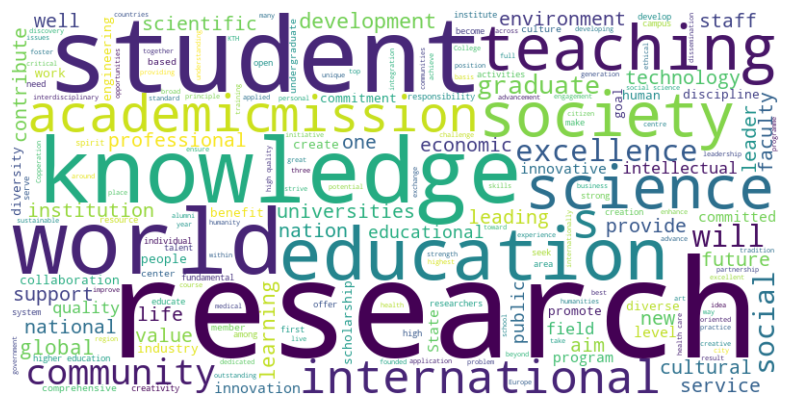

In [20]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

---

## Exercise 3 

In [21]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

import graphviz

Let's improve on the model used in class: decision tree on the bank dataset. (40%) 

**a)** In class we solved a classification problem on the *bank.csv* dataset using the kNN algorithm. The classifier performed poorly. Repeat the analysis carried out in class (based on the Notebook02), but now use a decision tree, set the maximum depth to be 6! **Hint:** Use the *tree.DecisionTreeClassifier* classifier!


In [22]:
bank_data = pd.read_csv("bank.csv", delimiter = " ", names = ['age', 'sex', 'region', 'income', 'married', 'children', 'car','save_acct', 'current_acct', 'mortgage', 'pep'])

numeric_data = bank_data.replace(['NO', 'YES', 'MALE', 'FEMALE'],[0,1,0,1])

one_hot = pd.get_dummies(numeric_data['region'])
one_hot = one_hot.replace([True,False],[1,0])
numeric_data = numeric_data.drop('region', axis = 1)
numeric_data = numeric_data.join(one_hot)

bank_labels = numeric_data['pep']
bank_attrs = numeric_data.drop('pep', axis=1)

bank_features_train, bank_features_test, bank_labels_train, bank_labels_test = train_test_split(bank_attrs, bank_labels, test_size=0.25, random_state=42)

In [23]:
decision_tree_classifier = DecisionTreeClassifier(max_depth=6)

decision_tree_classifier.fit(bank_features_train, bank_labels_train)
bank_labels_pred = decision_tree_classifier.predict(bank_features_test)

accuracy = accuracy_score(bank_labels_test, bank_labels_pred)
print(f'Accuracy of the decision tree classifier: {accuracy:.2f}')

Accuracy of the decision tree classifier: 0.84


**b)** Now fit the tree using different parameters! Plot the ROC curve of the decision tree obtained in part a) and the new tree in the same figure (with different colors). Also plot the *y=x* diagonal line!

In [24]:
new_decision_tree_classifier = DecisionTreeClassifier(max_depth=6, criterion='entropy', min_samples_split=4)
new_decision_tree_classifier.fit(bank_features_train, bank_labels_train)

bank_labels_prob = decision_tree_classifier.predict_proba(bank_features_test)[:, 1]
new_bank_labels_prob = new_decision_tree_classifier.predict_proba(bank_features_test)[:, 1]

fpr, tpr, _ = roc_curve(bank_labels_test, bank_labels_prob)
new_fpr, new_tpr, _ = roc_curve(bank_labels_test, new_bank_labels_prob)

roc_auc = auc(fpr, tpr)
new_roc_auc = auc(new_fpr, new_tpr)

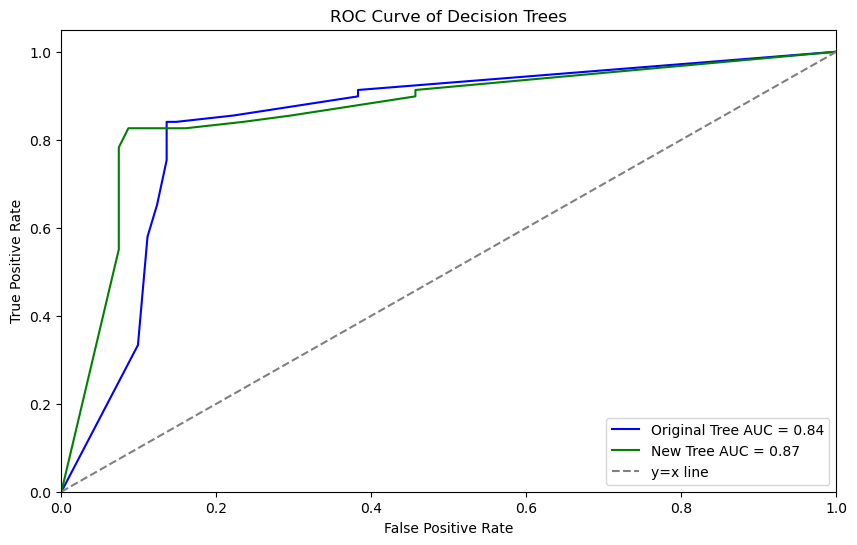

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'Original Tree AUC = {roc_auc:.2f}')
plt.plot(new_fpr, new_tpr, color='green', label=f'New Tree AUC = {new_roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='y=x line')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Decision Trees')
plt.legend(loc='lower right')
plt.show()

**c)** Plot and interpret the decision tree. The easiest way to do this is with the sklearn.tree.plot_tree function. Here's a useful article: https://pythoninoffice.com/how-to-a-plot-decision-tree-in-python/.

* If you would like, you can try plotting the decision tree using the graphviz package too. **Hints:** Visualize the decision tree trained in part a) using the *tree.export_graphviz* function. To present the tree use the *graphviz.Source* function or the *SVG* function of the *Ipython.display* package! If *graphviz* is not installed you can install it using the Anaconda Navigator or by using *pip install* or by installing with homebrew, *brew install graphviz*. If it doesn't seem to work you can also download it from this [link](https://graphviz.gitlab.io/download/) and inserting the following lines of codes (use the correct path for your downloaded file):<br><br>
import os <br>
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin') <br><br>

* <span style="color:red">Briefly interpret the results! According to what attribute did we split the tree first? Which were the usual splitting attributes? </span>

  <span style="color:blue">The first splitting attribute was: Income <= 29669.75 </span>   
  <span style="color:blue"> Usual splitting attributes were: children, married, age, mortgage, car, current account, TOWN, RURAL, have_account. </span>

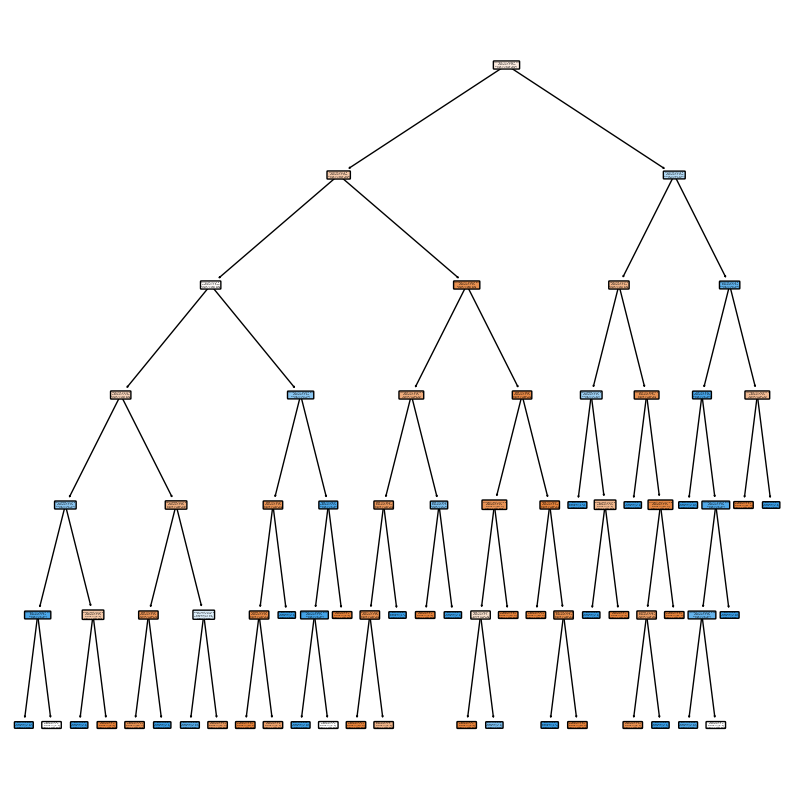

In [26]:
fig, ax = plt.subplots(figsize=(10,10))
_ = tree.plot_tree(
    decision_tree_classifier, 
    feature_names = bank_features_train.columns.tolist(), 
    class_names = ['Not PEP', 'PEP'], 
    filled=True,
    rounded=True
)
plt.show()

**d)** Plot the feature importances for the decision tree. The link in part c) also has useful information about this. <span style="color:red"> Briefly interpret. </span>    
<span style="color:blue"> Income and children are the most important features.    
    This makes sense as they make up the majority of the splitting attributes on the first four levels.    
    The less important features mostly come up near the leaves of the tree.    
    Sex and surbuban are not splitting attributes on our tree ar all, and so their importance is zero. </span>

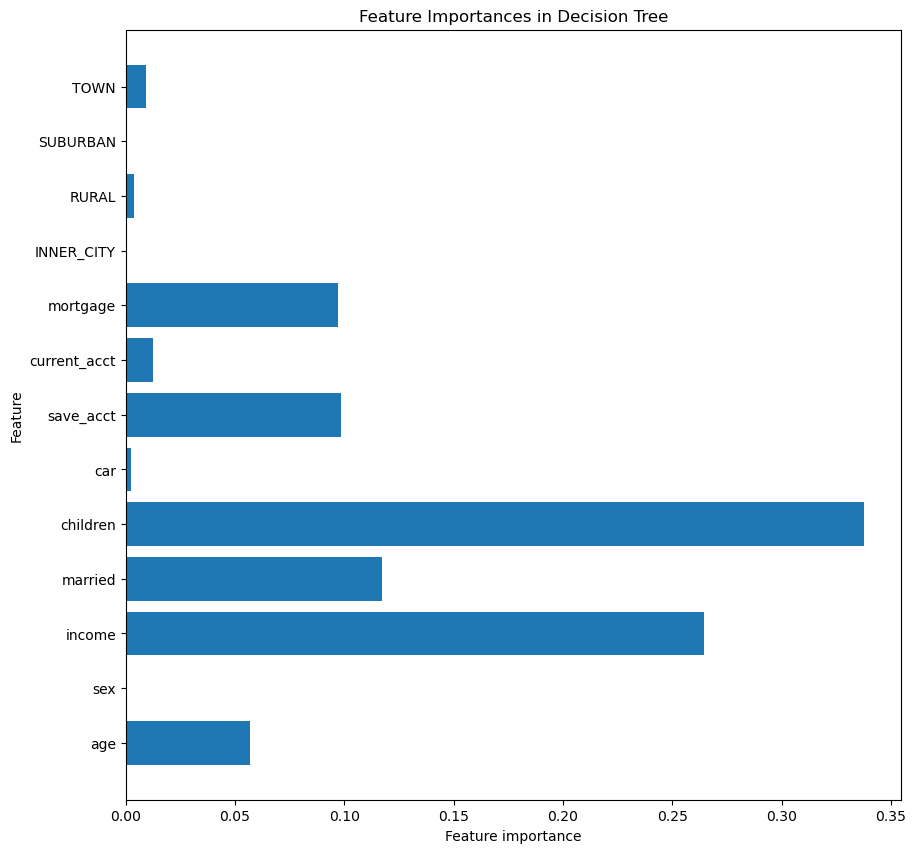

In [27]:
importances = decision_tree_classifier.feature_importances_

fig, ax = plt.subplots(figsize=(10, 10))
indices = range(len(importances))

plt.barh(indices, importances, align='center')
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.yticks(indices, bank_features_train.columns.tolist())
plt.title('Feature Importances in Decision Tree')
plt.show()

## Works Cited:

Please cite all external resources you used to complete this assignment. If you used ChatGPT, please include a link to the conversation.

https://pandas.pydata.org/docs/   
https://stackoverflow.com/   
https://matplotlib.org/stable/index.html   
https://en.wikipedia.org/wiki/2002   

https://roundranking.com/ranking/world-university-rankings.html#world-2021    
https://amueller.github.io/word_cloud/   

https://chat.openai.com/share/f87aebe3-dee6-4c05-9307-633d6f9465e9  